In [1]:
import sys
!{sys.executable} -m pip install -U xgboost


[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: D:\PYTHON_PROJECTS\credit_scoring_project\venv\Scripts\python.exe -m pip install --upgrade pip


In [28]:
#basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import copy
warnings.filterwarnings("ignore")
import time
random_state=42

#preprocessing
from sklearn.preprocessing import StandardScaler

#feature engineering
from sklearn.feature_selection import mutual_info_regression

#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

#algorithms
from lightgbm import LGBMRegressor, early_stopping
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import optuna

#model evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

#stacking


#feature selection


**First look to data**

In [3]:
train = pd.read_csv('data/raw/train.csv', index_col=[0])
test = pd.read_csv('data/raw/test.csv', index_col=[0])
train.head(5)

RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
id                                                              
0      0.603610      -7.636942      0.023500         0.000005   
1      0.639451     -16.267598      0.071520         0.444929   
2      0.514538     -15.953575      0.110715         0.173699   
3      0.734463      -1.357000      0.052965         0.001651   
4      0.532968     -13.056437      0.023500         0.068687   

    InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
id                                                                             
0            0.000001                   0.051385   0.409866      290715.6450   
1            0.349414                   0.170522   0.651010      164519.5174   
2            0.453814                   0.029576   0.423865      174495.5667   
3            0.159717                   0.086366   0.278745      225567.4651   
4            0.000001                   0.331345   0.477769      213960.6789   

      Energy  BeatsPerMinute  
id                            
0   0.826267       147.53020  
1   0.145400       136.15963  
2   0.624667        55.31989  
3   0.487467       147.91212  
4   0.947333        89.58511

In [4]:
#reserved for pipieline
pipe_train = train.copy()
pipe_test = test.copy()

#for data analysis
train_df = train.copy()
test_df = test.copy()
train_df.head(5)

RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
id                                                              
0      0.603610      -7.636942      0.023500         0.000005   
1      0.639451     -16.267598      0.071520         0.444929   
2      0.514538     -15.953575      0.110715         0.173699   
3      0.734463      -1.357000      0.052965         0.001651   
4      0.532968     -13.056437      0.023500         0.068687   

    InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
id                                                                             
0            0.000001                   0.051385   0.409866      290715.6450   
1            0.349414                   0.170522   0.651010      164519.5174   
2            0.453814                   0.029576   0.423865      174495.5667   
3            0.159717                   0.086366   0.278745      225567.4651   
4            0.000001                   0.331345   0.477769      213960.6789   

      Energy  BeatsPerMinute  
id                            
0   0.826267       147.53020  
1   0.145400       136.15963  
2   0.624667        55.31989  
3   0.487467       147.91212  
4   0.947333        89.58511

**Explore data analysis**

In [5]:
train_df.describe().T

count           mean           std  \
RhythmScore                524164.0       0.632843      0.156899   
AudioLoudness              524164.0      -8.379014      4.616221   
VocalContent               524164.0       0.074443      0.049939   
AcousticQuality            524164.0       0.262913      0.223120   
InstrumentalScore          524164.0       0.117690      0.131845   
LivePerformanceLikelihood  524164.0       0.178398      0.118186   
MoodScore                  524164.0       0.555843      0.225480   
TrackDurationMs            524164.0  241903.692949  59326.601501   
Energy                     524164.0       0.500923      0.289952   
BeatsPerMinute             524164.0     119.034899     26.468077   

                                    min            25%            50%  \
RhythmScore                    0.076900       0.515850       0.634686   
AudioLoudness                -27.509725     -11.551933      -8.252499   
VocalContent                   0.023500       0.023500       0.066425   
AcousticQuality                0.000005       0.069413       0.242502   
InstrumentalScore              0.000001       0.000001       0.074247   
LivePerformanceLikelihood      0.024300       0.077637       0.166327   
MoodScore                      0.025600       0.403921       0.564817   
TrackDurationMs            63973.000000  207099.876625  243684.058150   
Energy                         0.000067       0.254933       0.511800   
BeatsPerMinute                46.718000     101.070410     118.747660   

                                     75%            max  
RhythmScore                     0.739179       0.975000  
AudioLoudness                  -4.912298      -1.357000  
VocalContent                    0.107343       0.256401  
AcousticQuality                 0.396957       0.995000  
InstrumentalScore               0.204065       0.869258  
LivePerformanceLikelihood       0.268946       0.599924  
MoodScore                       0.716633       0.978000  
TrackDurationMs            281851.658500  464723.228100  
Energy                          0.746000       1.000000  
BeatsPerMinute                136.686590     206.037000

**Grouping features for preprocessing purpose**

In [6]:
numerical_features = [feature for feature in train_df.columns if feature!='BeatsPerMinute']
target = "BeatsPerMinute"

Sampling data for eda

In [7]:
sampled_train = train_df.sample(frac = 0.01)

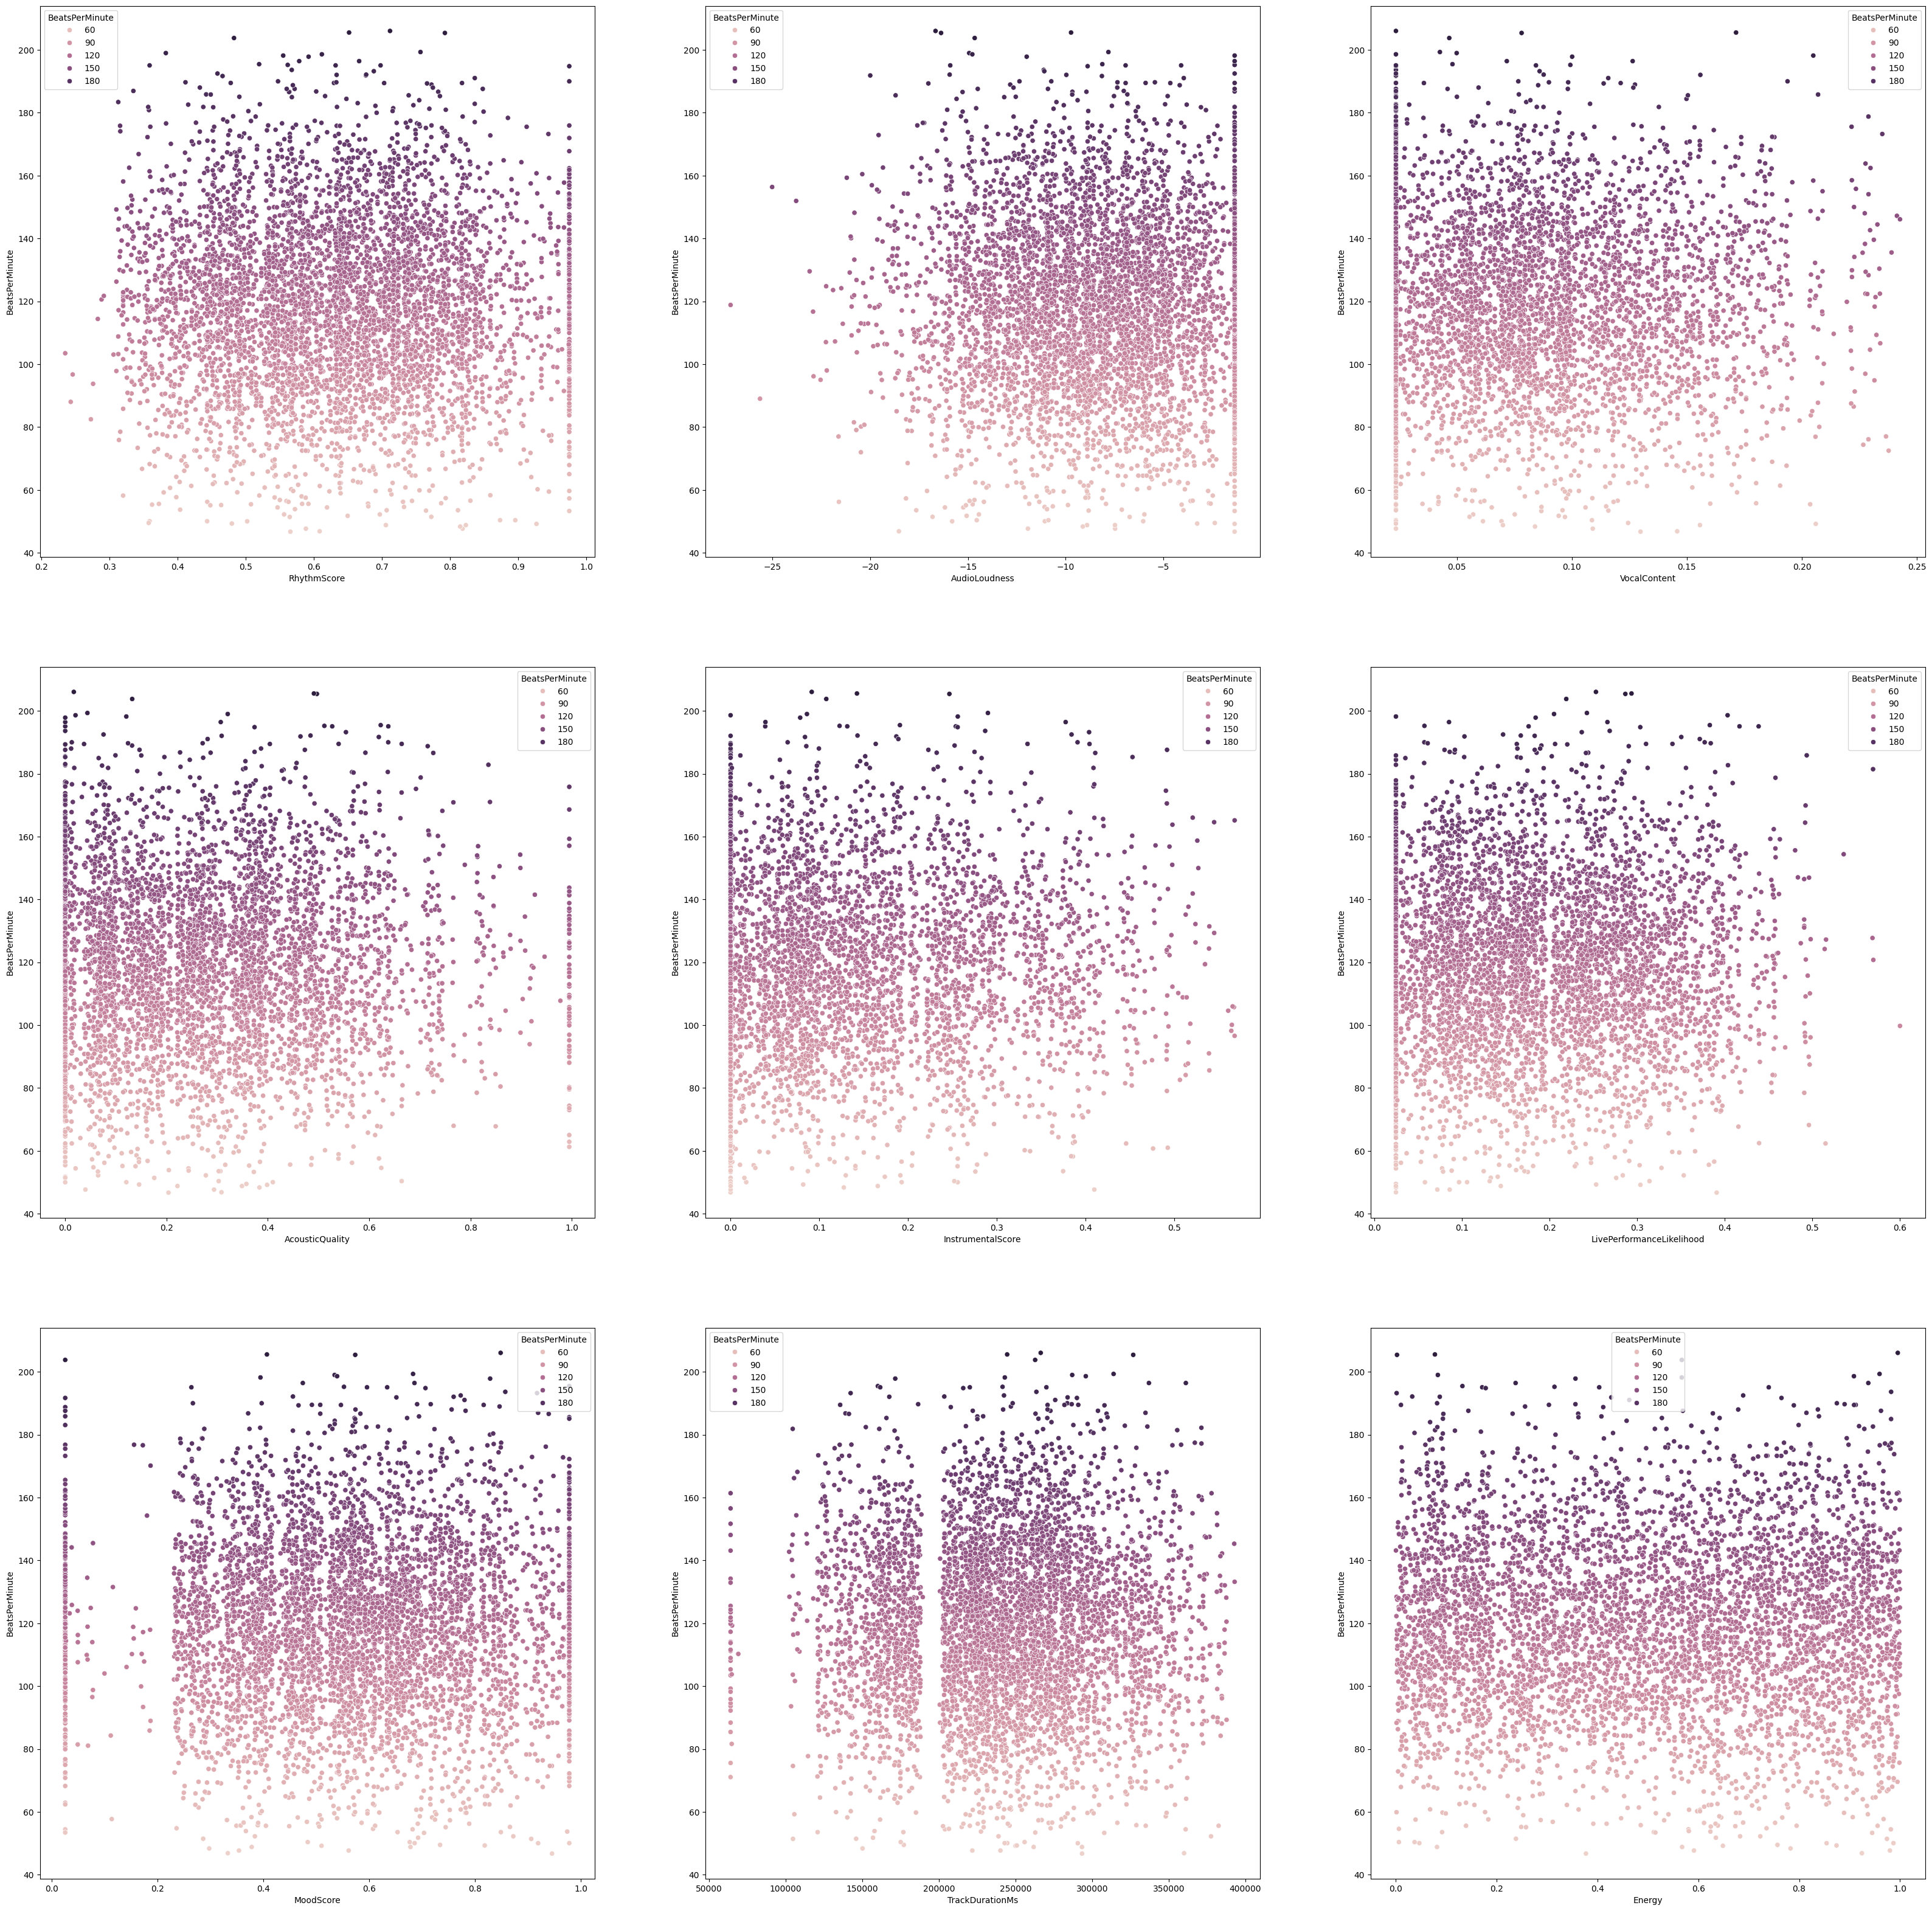

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(40, 40))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.scatterplot(x=var, y='BeatsPerMinute', data = sampled_train, ax=subplot, hue = 'BeatsPerMinute')

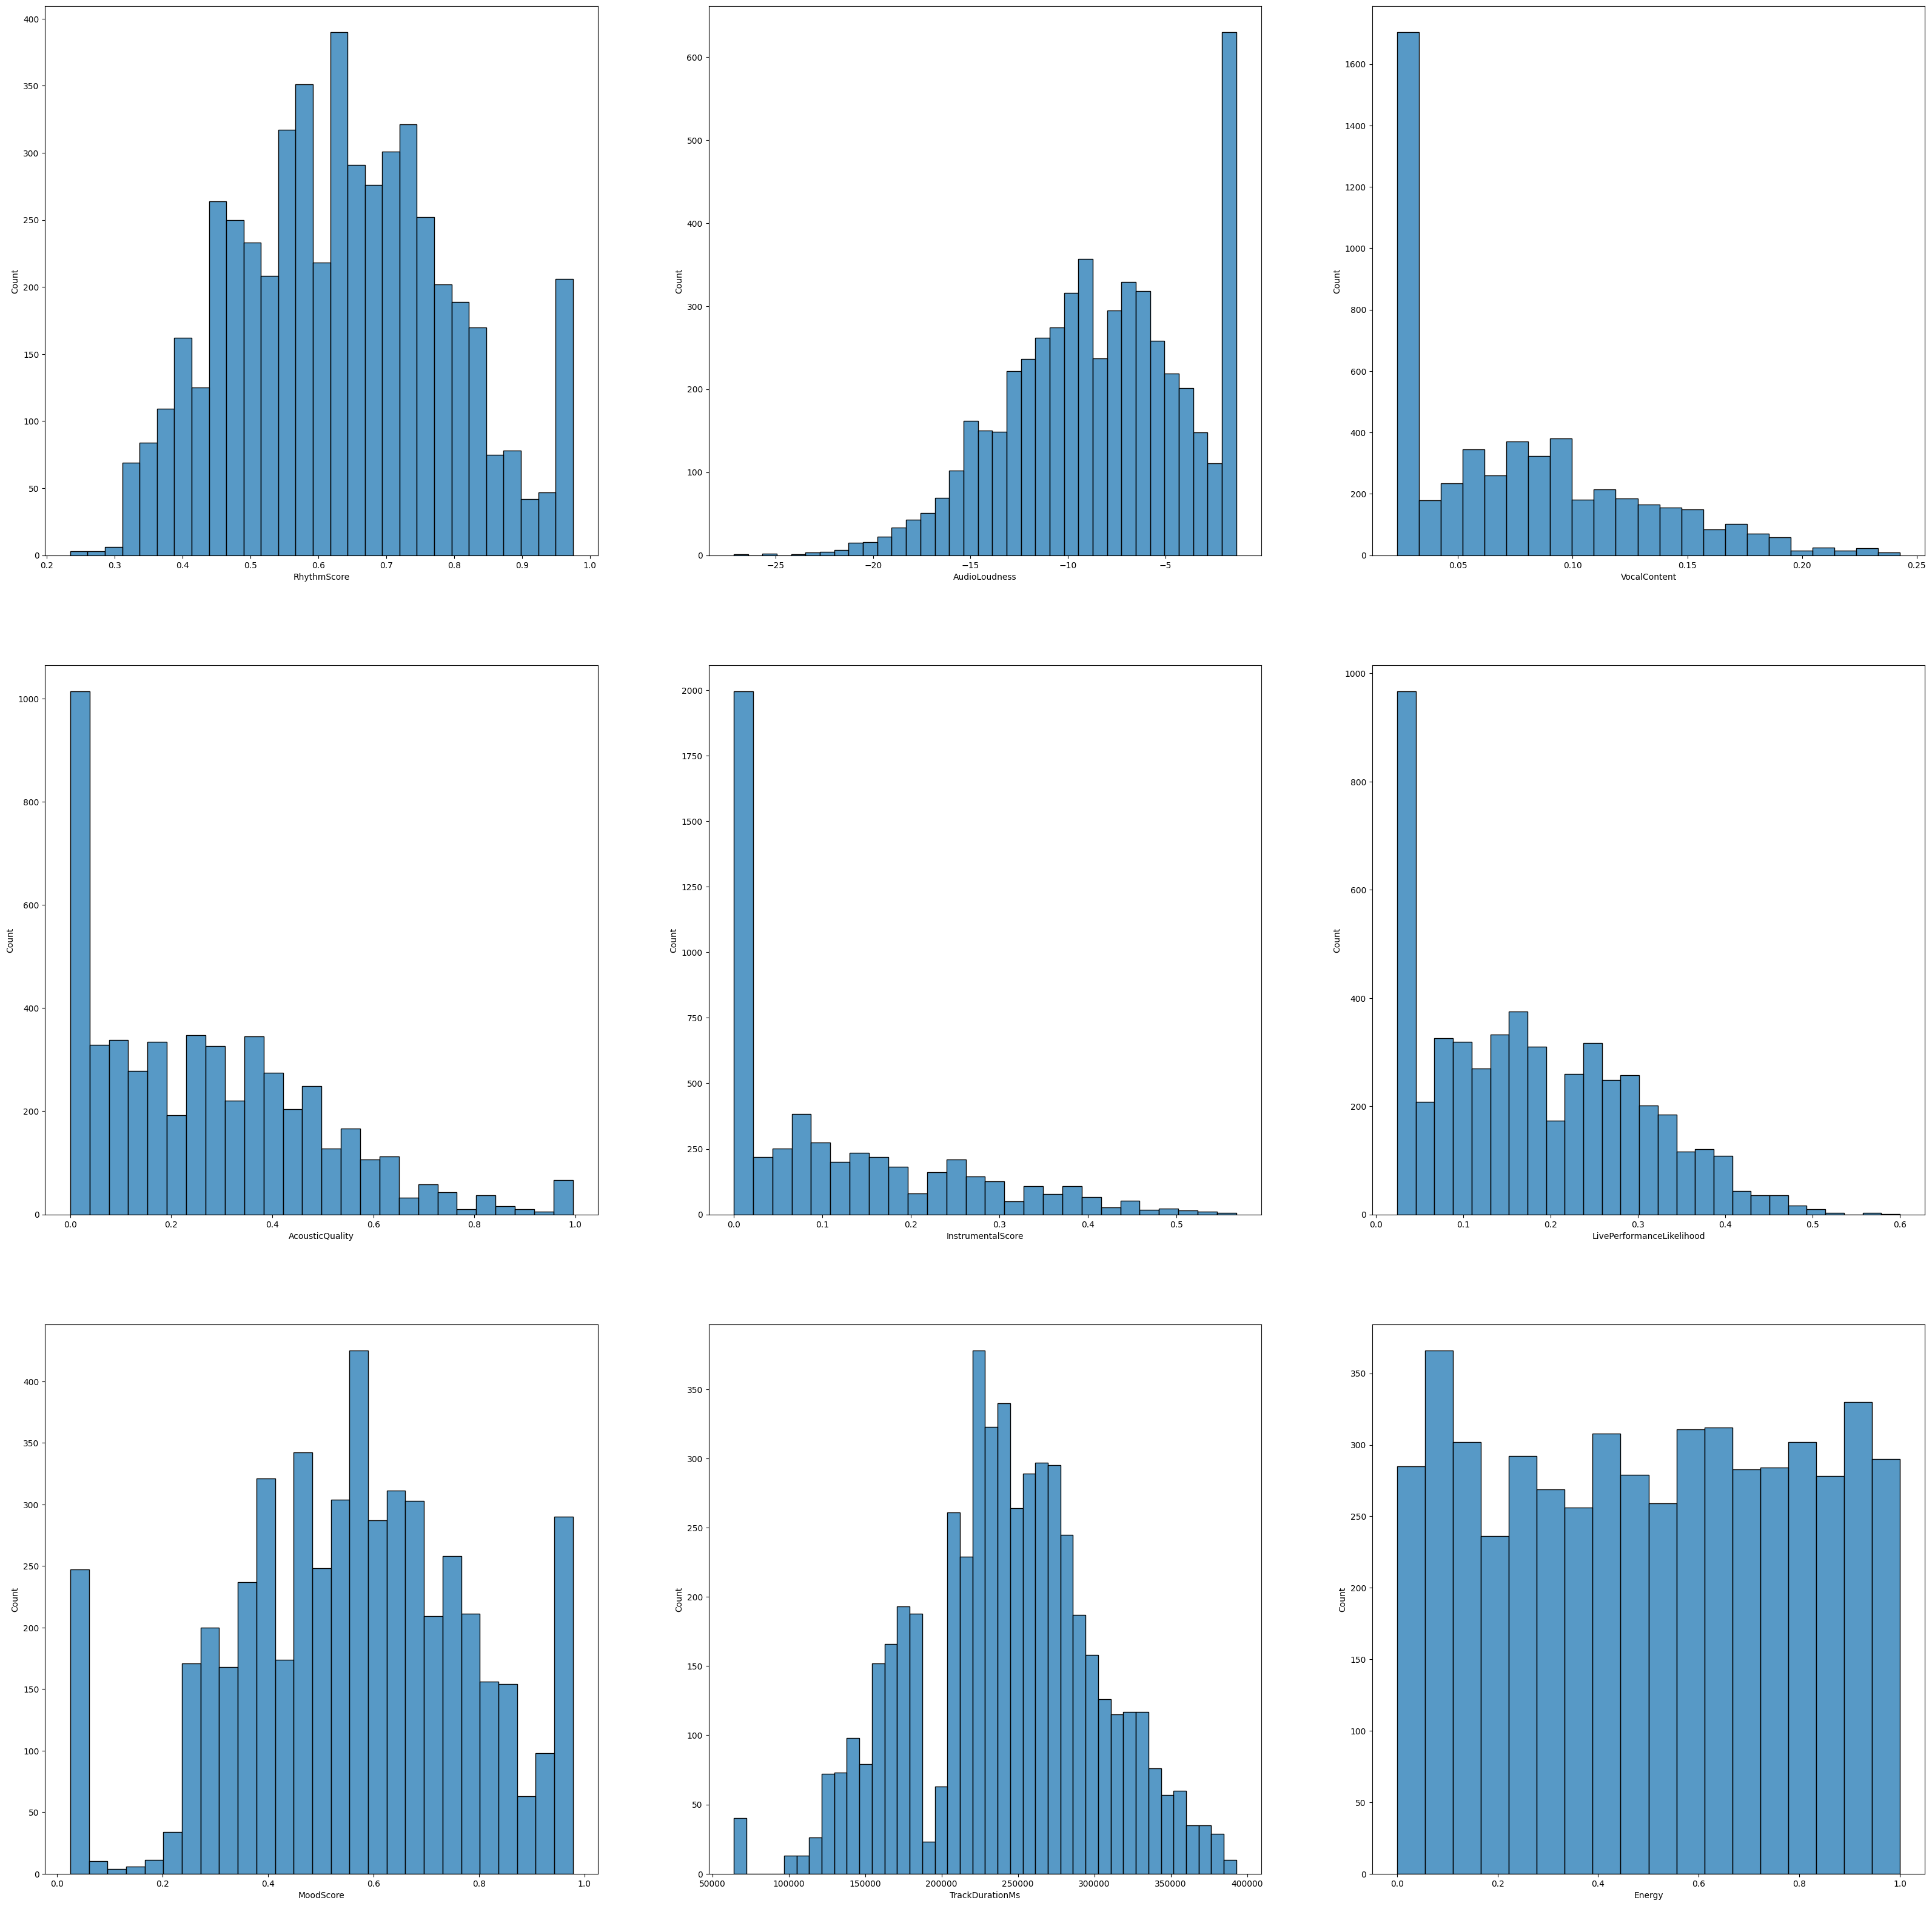

In [9]:
fig, ax = plt.subplots(3,3, figsize=(40,40))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.histplot(x=var, data=sampled_train, ax=subplot)

A lot of features have zero-inflated distribution

In [10]:
def extended_describe(df):
    desc = df.describe().T
    desc["median"] = df.median()
    desc["~zeros_count"] = ((df < 0.05) & (df > 0)).sum().values
    desc["~zeros_percent"] = (((df < 0.05) & (df > 0)).sum() / len(df) * 100).values
    desc["mode"] = [df[col].mode().iloc[0] if not df[col].mode().empty else np.nan for col in df.columns]
    desc.drop(columns=["25%", "50%", "75%"], inplace=True)
    return desc

extended_describe(train_df)

count           mean           std  \
RhythmScore                524164.0       0.632843      0.156899   
AudioLoudness              524164.0      -8.379014      4.616221   
VocalContent               524164.0       0.074443      0.049939   
AcousticQuality            524164.0       0.262913      0.223120   
InstrumentalScore          524164.0       0.117690      0.131845   
LivePerformanceLikelihood  524164.0       0.178398      0.118186   
MoodScore                  524164.0       0.555843      0.225480   
TrackDurationMs            524164.0  241903.692949  59326.601501   
Energy                     524164.0       0.500923      0.289952   
BeatsPerMinute             524164.0     119.034899     26.468077   

                                    min            max         median  \
RhythmScore                    0.076900       0.975000       0.634686   
AudioLoudness                -27.509725      -1.357000      -8.252499   
VocalContent                   0.023500       0.256401       0.066425   
AcousticQuality                0.000005       0.995000       0.242502   
InstrumentalScore              0.000001       0.869258       0.074247   
LivePerformanceLikelihood      0.024300       0.599924       0.166327   
MoodScore                      0.025600       0.978000       0.564817   
TrackDurationMs            63973.000000  464723.228100  243684.058150   
Energy                         0.000067       1.000000       0.511800   
BeatsPerMinute                46.718000     206.037000     118.747660   

                           ~zeros_count  ~zeros_percent          mode  
RhythmScore                           0        0.000000      0.975000  
AudioLoudness                         0        0.000000     -1.357000  
VocalContent                     210940       40.243130      0.023500  
AcousticQuality                  112152       21.396357      0.000005  
InstrumentalScore                224965       42.918819      0.000001  
LivePerformanceLikelihood         99115       18.909158      0.024300  
MoodScore                         25073        4.783427      0.025600  
TrackDurationMs                       0        0.000000  63973.000000  
Energy                            26116        4.982410      0.515467  
BeatsPerMinute                        0        0.000000    103.801320

<Axes: >

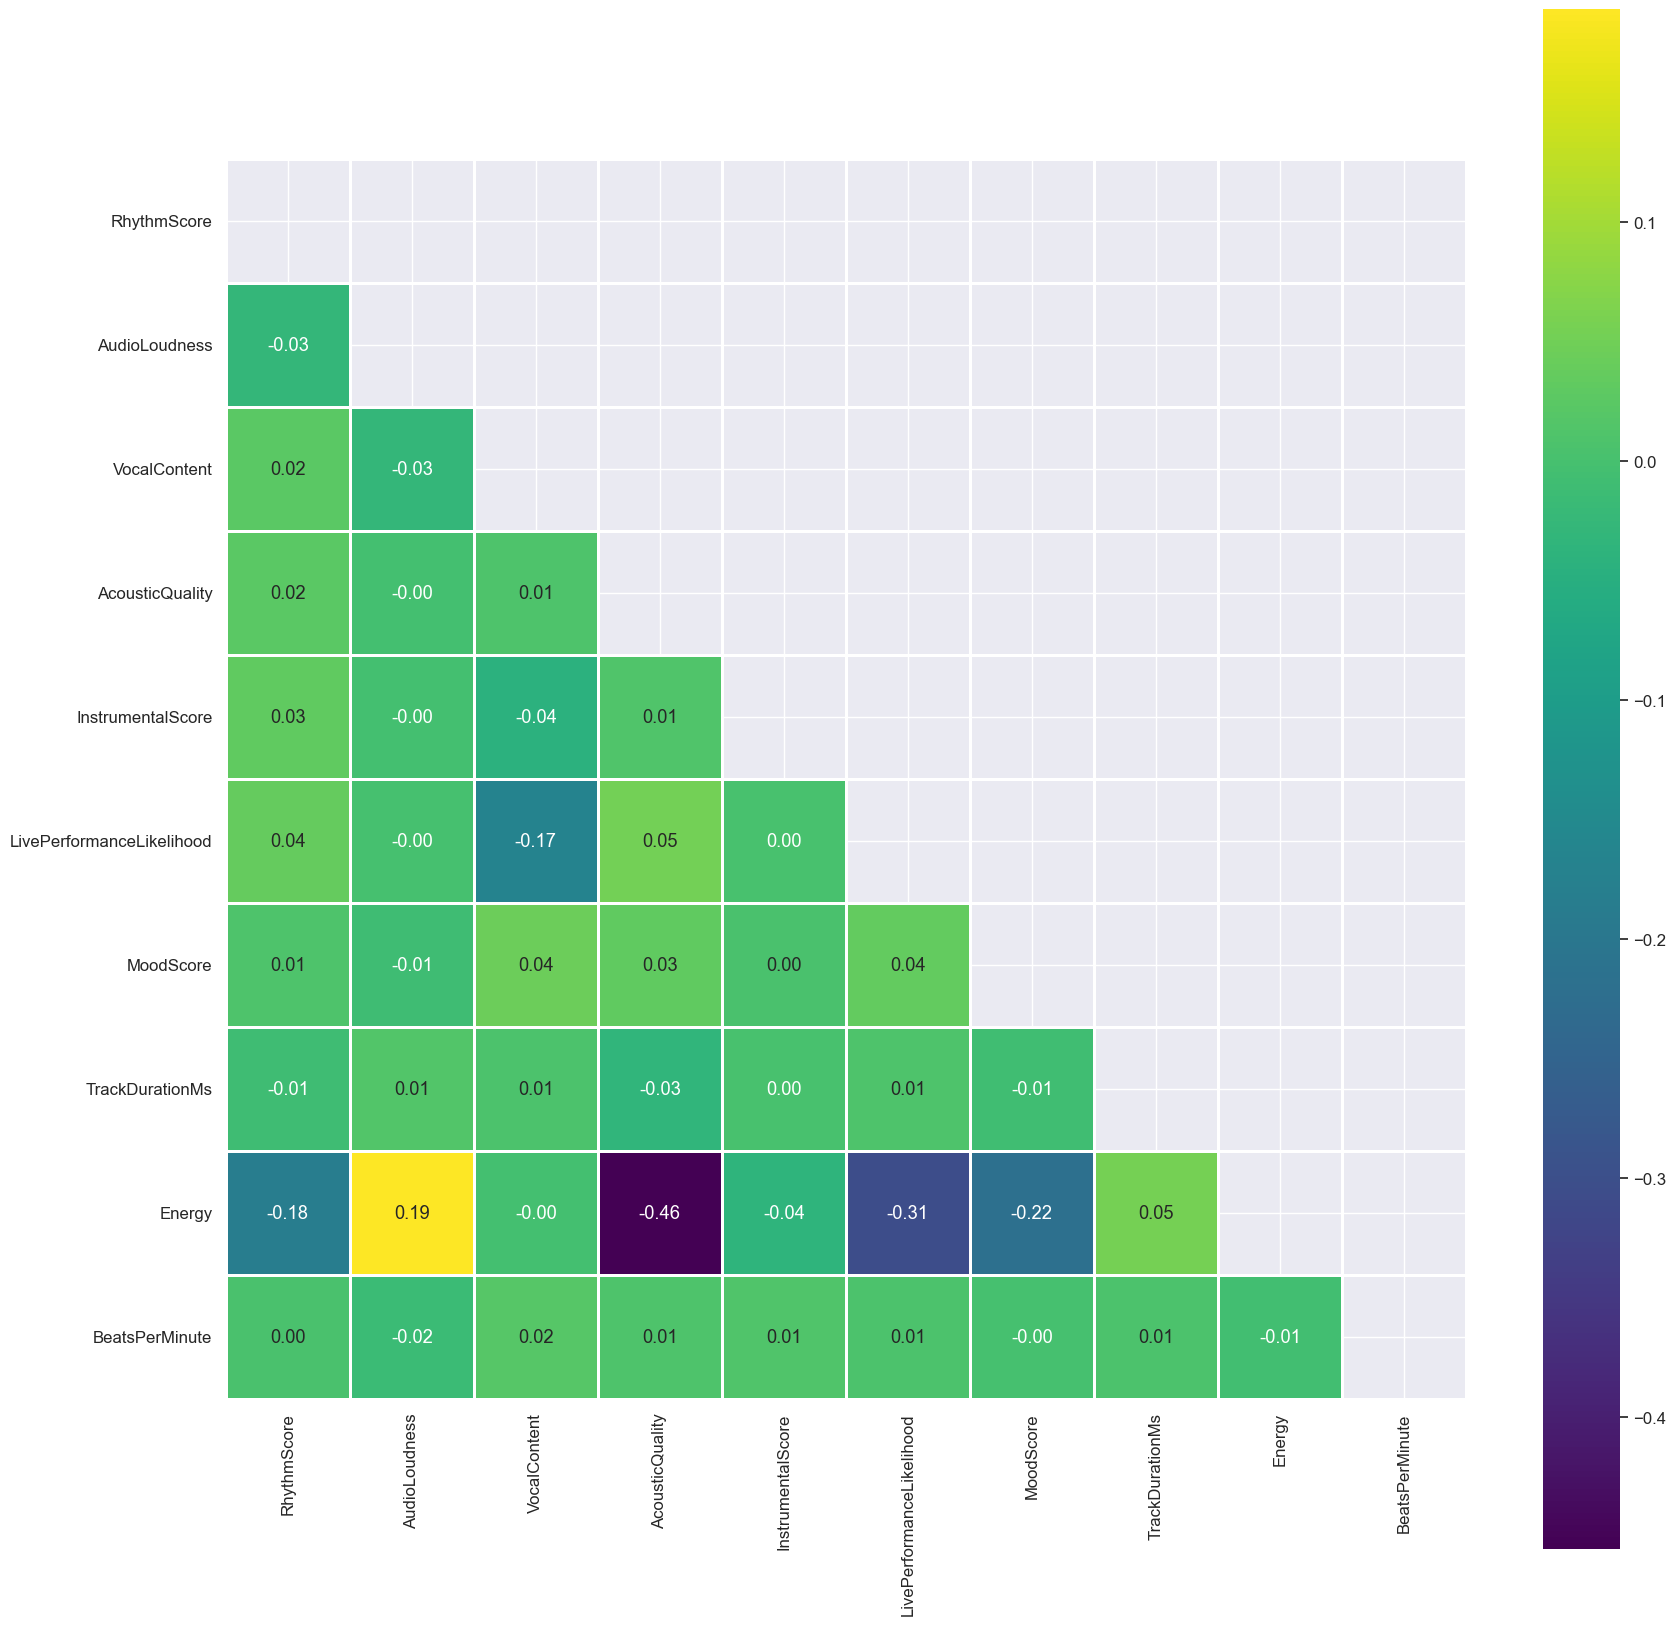

In [11]:
# Display correlations between numerical features and target on heatmap.
sns.set(font_scale=1.1)
corr_train = sampled_train.corr(method="spearman")
mask = np.triu(corr_train.corr(method="spearman"))
plt.figure(figsize=(20,20))
sns.heatmap(corr_train, annot=True, fmt='.2f', cmap='viridis', square=True, mask=mask, linewidths=1)

In [12]:
# Mutual Information score
y_sampled = sampled_train.BeatsPerMinute
features_sampled = sampled_train[numerical_features]

mutual_info = mutual_info_regression(features_sampled, y_sampled, random_state=random_state)
mutual_info_s = pd.Series(mutual_info)
mutual_info_s.index = features_sampled.columns
mutual_info_s = pd.DataFrame(mutual_info_s.sort_values(ascending=False), columns = ['Num Feature'])
mutual_info_s.style.background_gradient("cool")

**Target distribution**

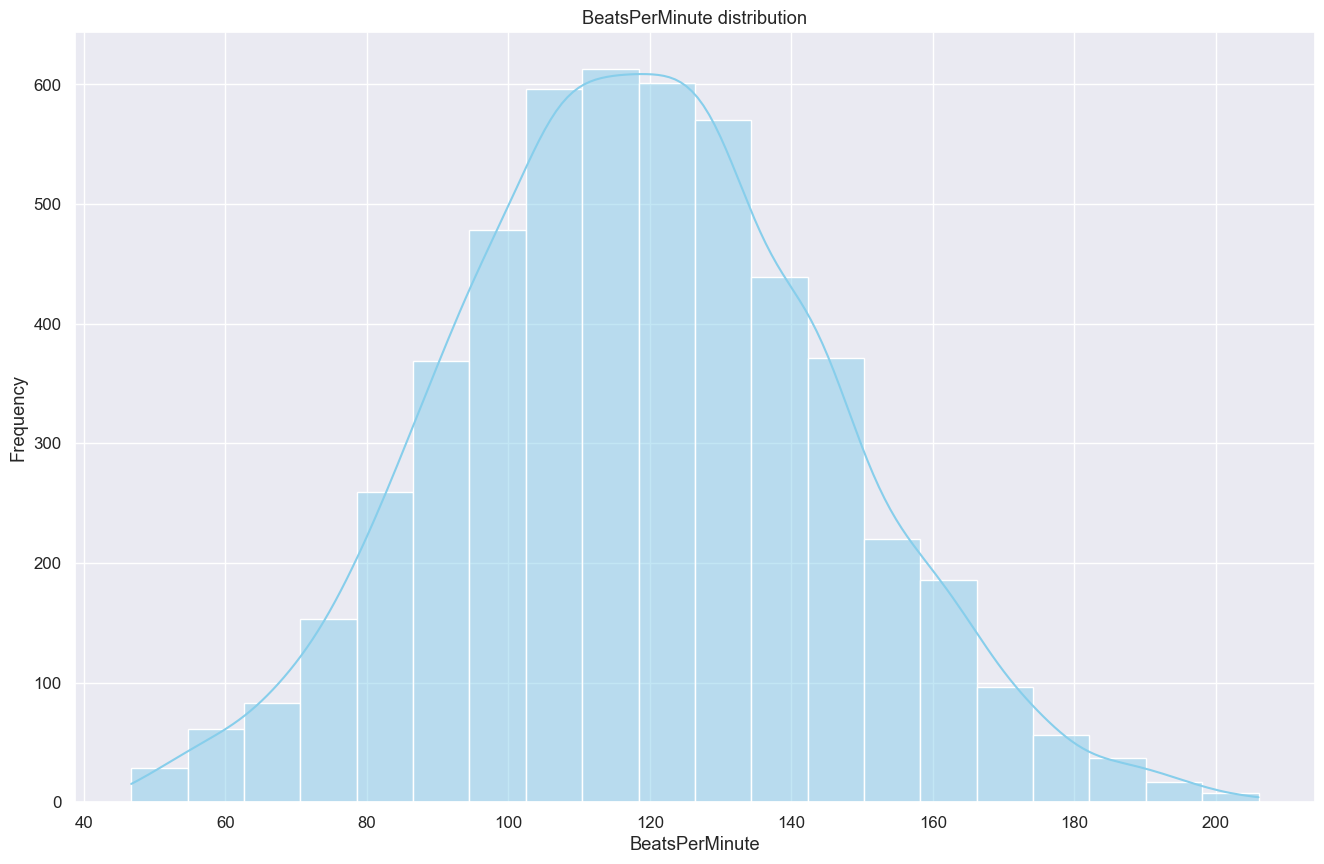

In [13]:
plt.figure(figsize=(16,10))
sns.histplot(x='BeatsPerMinute', data=sampled_train, bins=20, color='Skyblue', kde=True)
plt.title('BeatsPerMinute distribution')
plt.ylabel('Frequency')
plt.xlabel('BeatsPerMinute')
plt.show()

**Feature Engineering**

In [14]:
#Place to some FE

In [15]:
#Custom transformer

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, add_attributes=True):
        self.add_attributes = add_attributes
        self.new_feature_names = []
    def fit(self, X, y=None):
        #Placeholder
        return self
    
    def transform(self, X):
        # Placeholder
        return X
    
    def get_feature_names_out(self, input_features=None):
        # Output feature names
        if self.add_attributes:
            return self.new_feature_names
        else:
            return list(input_features) if input_features is not None else []
FeatureEngineer = FeatureEngineer()

**Preprocessing**

In [16]:
numerical_transformer = StandardScaler()

**Modeling**

In [17]:
cross_valid = KFold(n_splits=10, random_state=random_state, shuffle=True)

In [18]:
def cv_score(model,
    data,
    cross_valid,
    label='BeatsPerMinute',
    early_stopping_rounds=50):
    
    X = data.copy()
    y = X.pop(label)
    
    #Preparing variables for predictions
    val_predictions = np.zeros(len(X))
    val_true = np.zeros(len(y))
    val_scores, train_scores = [], []
    for fold, (train_idx, val_idx) in enumerate(cross_valid.split(X, y)):
        X_train, y_train = X.iloc[train_idx].reset_index(drop=True), y.iloc[train_idx].reset_index(drop=True)
        X_val, y_val = X.iloc[val_idx].reset_index(drop=True), y.iloc[val_idx].reset_index(drop=True)
        # Early stopping logic
        fit_params = {}
        if early_stopping_rounds is not None:
            # XGBoost
            if isinstance(model, XGBRegressor):
                pass
            #         fit_params['early_stopping_rounds'] = early_stopping_rounds
            #         fit_params['eval_set'] = [(X_val, y_val)]
            #         fit_params['verbose'] = False
                # except TypeError:
                #     from xgboost.callback import EarlyStopping
                #     fit_params['callbacks'] = [EarlyStopping(rounds=early_stopping_rounds, save_best=True)]
                #     fit_params['eval_set'] = [(X_val, y_val)]
        
            # CatBoost
            elif isinstance(model, CatBoostRegressor):
                fit_params['early_stopping_rounds'] = early_stopping_rounds
                fit_params['eval_set'] = [(X_val, y_val)]
                fit_params['verbose'] = False
        
            # LightGBM
            elif isinstance(model, LGBMRegressor):
                from lightgbm import early_stopping
                fit_params['callbacks'] = [early_stopping(stopping_rounds=early_stopping_rounds)]
                fit_params['eval_set'] = [(X_val, y_val)]
        if fit_params:    
            model.fit(X_train, y_train, **fit_params)
        else:
            model.fit(X_train, y_train)
            
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)

        val_predictions[val_idx] = val_preds
        val_true[val_idx] = y_val

        # Metics(RMSE)
        train_score = np.sqrt(mean_squared_error(y_train, train_preds))
        val_score   = np.sqrt(mean_squared_error(y_val, val_preds))

        train_scores.append(train_score)
        val_scores.append(val_score)

    # Result  is mean of RMSE on validation and training folds
    print(f"Val RMSE: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | "
          f"Train RMSE: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f}")

    return val_scores, val_predictions, val_true

In [19]:
val_scores_df, val_predictions_df, val_true_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

**Linear regresion RIDGE**

In [20]:
ridge_optuna_params = {'max_iter': 969,
                       'alpha': 996.2276353844511,
                       'tol': 4.41828902390748e-05}

ridge_tuned = Ridge(**ridge_optuna_params, random_state=random_state)
ridge_pipe = Pipeline(steps=[
    #('FeatureEngineer', FeatureEngineer),
    ('numerical_transformer', numerical_transformer),
    ('ridge', ridge_tuned)
])

ridge_pipe

Pipeline(steps=[('numerical_transformer', StandardScaler()),
                ('ridge',
                 Ridge(alpha=996.2276353844511, max_iter=969, random_state=42,
                       tol=4.41828902390748e-05))])

In [21]:
%%time
val_scores_df['ridge'], val_predictions_df['ridge'], val_true_df['ridge'] = cv_score(ridge_pipe, data = pipe_train, cross_valid=cross_valid)
pipe_train.head()

Val RMSE: 26.46611 ± 0.04192 | Train RMSE: 26.46572 ± 0.00466
CPU times: total: 1.83 s
Wall time: 4.32 s


RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
id                                                              
0      0.603610      -7.636942      0.023500         0.000005   
1      0.639451     -16.267598      0.071520         0.444929   
2      0.514538     -15.953575      0.110715         0.173699   
3      0.734463      -1.357000      0.052965         0.001651   
4      0.532968     -13.056437      0.023500         0.068687   

    InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
id                                                                             
0            0.000001                   0.051385   0.409866      290715.6450   
1            0.349414                   0.170522   0.651010      164519.5174   
2            0.453814                   0.029576   0.423865      174495.5667   
3            0.159717                   0.086366   0.278745      225567.4651   
4            0.000001                   0.331345   0.477769      213960.6789   

      Energy  BeatsPerMinute  
id                            
0   0.826267       147.53020  
1   0.145400       136.15963  
2   0.624667        55.31989  
3   0.487467       147.91212  
4   0.947333        89.58511

**XGBOOST**

In [ ]:
def objective(trial, data, cv):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "alpha": trial.suggest_float("alpha", 0.0, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
    }

    model = XGBRegressor(random_state=42, **params)
    print(type(model))
    scores = cv_score(model, data, cross_valid=cv)
    val_score = scores[0]
    return np.mean(val_score)

study = optuna.create_study(direction="minimize")
def save_best_params(study, trial):
    with open("xgboost_bestparams.json", "w") as f:
        json.dump(study.best_params, f, indent=4)
study.optimize(lambda trial: objective(trial, data = pipe_train, cv = cross_valid), n_trials=20, callbacks=[save_best_params])

print("Best RMSE:", study.best_trial.value)
print("Best params:", study.best_trial.params)

xgb_optuna_params = study.best_trial.params

# xgb_tuned = XGBRegressor(
#     **xgb_optuna_params,
#     random_state=random_state
#  )

# xgb_pipe = Pipeline(steps=[
#     ('FeatureEngineer', FeatureEngineer),
#     ('xgb_tuned', xgb_tuned)
# ])

# xgb_pipe

In [ ]:
val_scores_df['XGBOOST'], val_predictions_df['XGBOOST'], val_true_df['XGBOOST'] = cv_score(xgb_pipe, data = pipe_train,cross_valid=cross_valid)

**Random forest**

In [ ]:
def objective(trial, data, cv):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }

    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    print(type(model))
    scores = cv_score(model, data, cross_valid=cv)
    val_score = scores[0]
    return np.mean(val_score)
study = optuna.create_study(direction="minimize")
def save_best_params(study, trial):
    with open("randomforest_bestparams.json", "w") as f:
        json.dump(study.best_params, f, indent=4)
study.optimize(lambda trial: objective(trial, data = pipe_train, cv = cross_valid), n_trials=20, callbacks=[save_best_params])
print("Best RMSE:", study.best_trial.value)
print("Best params:", study.best_trial.params)

rf_optuna_params = study.best_trial.params
rf_tuned = RandomForestRegressor(
    **rf_optuna_params,
    random_state=random_state,
    n_jobs=-1
)

rf_pipe = Pipeline(steps=[
    ('FeatureEngineer', FeatureEngineer),
    ('rf_tuned', rf_tuned)
])
rf_pipe

[I 2025-09-28 23:56:57,381] A new study created in memory with name: no-name-3ee51e2d-32ad-4035-b990-036a37a09e98


<class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [ ]:
val_scores_df['RF'], val_predictions_df['RF'], val_true_df['RF'] = cv_score(rf_pipe, data = pipe_train,cross_valid=cross_valid)